In [1]:
#$note my changes
BS_SIZE = 32 #delta from 64
N_EPOCHS = 10 #delta $mini

def free_gpu_cache():
    torch.cuda.empty_cache()

In [2]:
#meta 2/14/2021 Kaggle Cassava Example Resnet 50 by noelmat 
#credit to noelmat
#me: learning by example, this code looks concise -> errors out with CUDA, mitigate that

In [3]:
from fastai.vision.all import *

In [4]:
path = Path('/kaggle/input/cassava-leaf-disease-classification/')
path.ls()

(#7) [Path('/kaggle/input/cassava-leaf-disease-classification/train_tfrecords'),Path('/kaggle/input/cassava-leaf-disease-classification/sample_submission.csv'),Path('/kaggle/input/cassava-leaf-disease-classification/test_tfrecords'),Path('/kaggle/input/cassava-leaf-disease-classification/label_num_to_disease_map.json'),Path('/kaggle/input/cassava-leaf-disease-classification/train_images'),Path('/kaggle/input/cassava-leaf-disease-classification/train.csv'),Path('/kaggle/input/cassava-leaf-disease-classification/test_images')]

In [5]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [6]:
with open(path/'label_num_to_disease_map.json') as f:
    label_dict = json.load(f)

label_dict = {int(k):v for k,v in label_dict.items()}

<AxesSubplot:>

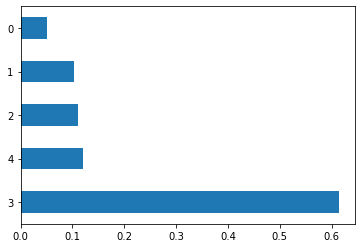

In [7]:
train_df['label'].value_counts(normalize=True).plot(kind='barh')

In [8]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
splits = {}

for i,(tr_idx,val_idx) in enumerate(cv.split(train_df, train_df['label'])):
    splits[i] = [tr_idx, val_idx]

In [9]:
df = train_df.set_index('image_id')
labels = df.to_dict()['label']

In [10]:
%%time
labels['1000723321.jpg']

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.39 µs


1

In [11]:
def get_label(labels, x):
    x = Path(x)
    return labels[x.name]

In [12]:
fn = train_df.iloc[0,0]

In [13]:
%%time
get_label(labels,path/'train_images'/fn)

CPU times: user 41 µs, sys: 10 µs, total: 51 µs
Wall time: 55.1 µs


0

In [14]:
def get_splits(FOLD, x):
    return splits[FOLD]

In [15]:
def get_data(labels,split,bs=BS_SIZE, presize=500, resize=384): #$mydelta
    tfms = [Rotate(90), Warp(magnitude=0.4, p=1.),Zoom(min_zoom=0.9, max_zoom=1.3), Brightness(max_lighting=0.5), Flip(), Contrast(), Resize(resize)]
    comp = setup_aug_tfms(tfms)
    return DataBlock(blocks=(ImageBlock, CategoryBlock),
        get_items=lambda p: get_image_files(p),
        get_y=partial(get_label, labels),
        splitter=partial(get_splits, split),
        item_tfms=[Resize(presize)],
        batch_tfms=[*comp, Normalize.from_stats(*imagenet_stats)]).dataloaders(path/'train_images',bs=bs,num_workers=8)

In [16]:
N_FOLDS=5

In [17]:
os.makedirs('/root/.cache/torch/hub/checkpoints/', exist_ok=True)

In [18]:
!cp /kaggle/input/fastai-pretrained/resnet50-19c8e357.pth /root/.cache/torch/hub/checkpoints/

In [19]:
#track time
t0 = time.time()

for split in range(N_FOLDS): #$mini
    #track fold time
    t1 = time.time()

    dls = get_data(labels,split,bs=BS_SIZE)
    
    free_gpu_cache() #mydelta
    
    learn = cnn_learner(dls, models.resnet50, metrics=[accuracy]).to_fp16()
    learn.freeze()
    # learn.lr_find()
    learn.fit_one_cycle(N_EPOCHS, 5e-3, cbs=[MixUp()]) #$mydelta
    learn.save(f'resnet50-frozen-fold_{split}')
    learn.unfreeze()
    learn.fit_one_cycle(N_EPOCHS, slice(1e-5, 1e-4), cbs=[MixUp()]) #$mydelta
    learn.save(f'resnet50-full-fold_{split}')
    
    #export model
    learn.export(f'/kaggle/working/model_{split}.pkl') 
    
    print ("Fold Training time (in min)", (time.time() - t1)/60)
    
print ("Total Training time (in min)", (time.time() - t0)/60)
    

epoch,train_loss,valid_loss,accuracy,time
0,1.038129,0.572311,0.810981,07:05
1,0.867038,1.410253,0.557009,06:53
2,0.802513,0.485671,0.833178,06:53
3,0.740229,0.507634,0.822664,06:54
4,0.717880,0.453921,0.837617,06:54
5,0.709171,0.382267,0.877336,06:54
6,0.671610,0.381146,0.872897,06:54
7,0.683451,0.374609,0.873832,06:55
8,0.636821,0.353414,0.885280,06:54
9,0.631331,0.350540,0.886215,06:53


epoch,train_loss,valid_loss,accuracy,time
0,0.615340,0.358400,0.882243,08:30
1,0.650119,0.369587,0.878271,08:31
2,0.650568,0.362338,0.880140,08:30
3,0.663404,0.347138,0.884579,08:28
4,0.652934,0.343832,0.886916,08:27
5,0.621074,0.347494,0.882243,08:28
6,0.622382,0.343326,0.887617,08:28
7,0.609909,0.333294,0.890888,08:28
8,0.594414,0.334189,0.891355,08:28
9,0.616634,0.331186,0.890187,08:27


Fold Training time (in min) 154.4710192600886


epoch,train_loss,valid_loss,accuracy,time
0,1.058031,0.523855,0.817757,06:51
1,0.852883,0.601693,0.775701,06:52
2,0.799305,0.496269,0.835514,06:50
3,0.777905,0.457071,0.844860,06:53
4,0.722409,0.371679,0.874065,06:53
5,0.697274,0.363492,0.880841,06:52
6,0.673650,0.358854,0.879439,06:53
7,0.675439,0.348057,0.882009,06:54
8,0.637310,0.329507,0.888084,06:55
9,0.638120,0.326734,0.888084,06:55


epoch,train_loss,valid_loss,accuracy,time
0,0.670499,0.329551,0.887383,08:32
1,0.663579,0.352139,0.879673,08:30
2,0.652019,0.358072,0.877804,08:32
3,0.646098,0.351600,0.885981,08:32
4,0.666624,0.346347,0.881075,08:31
5,0.611789,0.323779,0.889953,08:32
6,0.616045,0.335896,0.885748,08:32
7,0.627194,0.318072,0.891122,08:32
8,0.628039,0.314207,0.894159,08:33
9,0.600580,0.322226,0.890421,08:33


Fold Training time (in min) 154.3693999091784


epoch,train_loss,valid_loss,accuracy,time
0,0.978301,0.661153,0.775181,06:59
1,0.812053,0.551855,0.804861,06:58
2,0.808748,0.555766,0.821687,06:58
3,0.739528,0.453212,0.845525,06:56
4,0.709354,0.442144,0.853237,06:53
5,0.703128,0.429107,0.863286,06:53
6,0.670960,0.399455,0.870998,06:55
7,0.671943,0.378763,0.871699,06:52
8,0.648627,0.366626,0.874737,06:53
9,0.654632,0.368905,0.874270,06:53


epoch,train_loss,valid_loss,accuracy,time
0,0.644689,0.367585,0.875205,08:29
1,0.660772,0.380971,0.873101,08:28
2,0.659391,0.397261,0.865389,08:28
3,0.671039,0.364840,0.880112,08:29
4,0.640408,0.368010,0.874503,08:28
5,0.615948,0.360832,0.880346,08:30
6,0.603101,0.351520,0.880112,08:29
7,0.625281,0.350189,0.881982,08:29
8,0.617981,0.345525,0.887591,08:29
9,0.608175,0.348047,0.882215,08:30


Fold Training time (in min) 154.2264926036199


epoch,train_loss,valid_loss,accuracy,time
0,1.012041,0.621616,0.795513,06:53
1,0.860996,0.593985,0.793410,06:52
2,0.792580,0.525073,0.837579,06:53
3,0.718424,0.492300,0.833372,06:54
4,0.760005,0.440137,0.854405,06:53
5,0.684630,0.392424,0.871699,06:53
6,0.679779,0.372909,0.877775,06:53
7,0.660882,0.364623,0.877775,06:55
8,0.630491,0.347990,0.878944,06:53
9,0.632491,0.347881,0.881281,06:54


epoch,train_loss,valid_loss,accuracy,time


In [ ]:
#learn.recorder.plot_loss()

In [ ]:
#evaluate - out of memory
#interp = ClassificationInterpretation.from_learner(learn)
#interp.plot_confusion_matrix()